### (Seq2Seq) LSTM Autoencoder: using dataset of trajectories, predict trajectories
# Created by: Eley Ng 
# Stanford ARM-Lab

In [8]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import copy
from torch.autograd import Variable
import seaborn as sns
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from platform import python_version

## Generate Data

In [12]:
#####################
# Dataset generation
#####################
np.random.seed(seed=123) 

Ti = 0
Tf = 10
seg = 5 # length of trajectory observation / length of prediction (assume same length for now)
samples = 100
features = 2 # x,y

samp_freq = samples/(Tf-Ti)

t = np.linspace(Ti, Tf, num=samples+2*seg)

x = 2*t
y = 2*np.cos(t)

# Note: shape input into [samples, timesteps, features] to use with Pytorch data loader (future use)
data_in = np.zeros((samples, seg, features)) # data_in:= input trajectory
data_gt = np.zeros((samples, seg, features)) # data_gt:= target prediction trajectories

# Generate data (with option to add noise)
for i in range(samples):
    
    data_in[i,:,0] = x[i:i+seg] #+ np.random.normal(mean, cov)
    data_in[i,:,1] = y[i:i+seg] #+ np.random.normal(mean, cov)
    
    data_gt[i,:,0] = x[i+seg:i+seg*2] #+ np.random.normal(mean, cov)
    data_gt[i,:,1] = y[i+seg:i+seg*2] #+ np.random.normal(mean, cov)


# Printouts    
print('[samples, timesteps, features]:', data_in.shape) #, labels.shape)
print('99th sample dim: ', data_in[99,:,:])
print("Sampling frequency", samp_freq)

[samples, timesteps, features]: (100, 5, 2)
99th sample dim:  [[18.16513761 -1.88403128]
 [18.34862385 -1.93759404]
 [18.53211009 -1.97485988]
 [18.71559633 -1.99551538]
 [18.89908257 -1.99938681]]
Sampling frequency 10.0


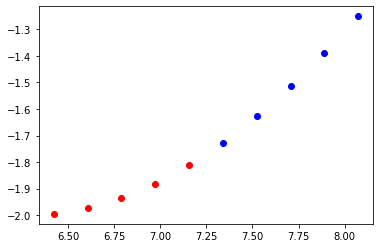

In [13]:
#####################
# Plot some data
#####################
s = 35

plt.plot(data_gt[s,:,0], data_gt[s,:,1], 'o', color='b') # Dataset
plt.plot(data_in[s,:,0], data_in[s,:,1], 'o', color='r') # Dataset
# plt.plot(x,y) # Real trajectory

## Create Model

In [27]:
### Encoder: 2 LSTMs, input: (batched) trajectories; output: the last hidden state for each sample in the batch
### The encoder embeds the input trajectory information into an layer that represents the input
### using many more features than the input has, and the LSTM helps encode the input's temporal information specifically

class Encoder(nn.Module):
    def __init__(self, batch_size, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.batch_size = batch_size
        self.embedding_dim, self.hidden_dim = embedding_dim, 2*embedding_dim
        self.lstm1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1, #not stacked lstm here but could be, except we decided to expand the hidden dim (to twice the size)
          batch_first=True # for pytorch. thankfully, our input is shaped as (batch, seq, feature) 
        )
        self.lstm2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim, 
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x = x.reshape((self.batch_size, self.seq_len, self.n_features))
        x, (_, _) = self.lstm1(x)
        x, (hidden_n, _) = self.lstm2(x)
        return hidden_n.reshape((self.batch_size, self.embedding_dim)) # for hidden size, only get last hidden state

In [28]:
### Decoder: 2 LSTMs, input: last hidden state for each batch; output: the trajectory prediction for each batch

class Decoder(nn.Module):
    def __init__(self, batch_size, pred_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.pred_len, self.input_dim = pred_len, input_dim #input dim is embedding dim from encoder
        self.batch_size = batch_size
        self.hidden_dim, self.n_features = input_dim, 4* n_features #2 * input_dim, n_features
        self.lstm1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.lstm2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features) # use output layer to reshape to the desired number of features
   
    def forward(self, x):
        x = torch.unsqueeze(x, 1) # add new dim along columns: the prediction length
        x = x.repeat(1, self.pred_len, 1)
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = x.reshape((self.batch_size, self.pred_len, self.hidden_dim))        

        return self.output_layer(x)

In [29]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, batch_size, seq_len, pred_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(batch_size, seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(batch_size, pred_len, embedding_dim, n_features).to(device)
        self.batch_size = batch_size
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
def make_batches(train_data, batch_size): 
    # Suggestion: randomize samples in batches
    batched_in = []
    batched_gt = []
    train_in, train_gt = train_data[0], train_data[1]
    N = train_in.shape[0]
    for i in range ( N // batch_size ):
        batched_in.append(train_in[i*batch_size:(i+1)*batch_size])
        batched_gt.append(train_gt[i*batch_size:(i+1)*batch_size])
    return batched_in, batched_gt

In [31]:
def train_model(model, train_dataset, val_dataset, n_epochs, batch_sz=10):
    
    train_in, train_gt = make_batches(train_dataset, batch_size)
    val_in, val_gt = make_batches(val_dataset, batch_size)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device) # L1 loss : more robust and is generally not affected by outliers
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict()) # keep best model; use deep copy for modules, clone for tensors
    best_loss = 10000.0
    
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        
        #batch training
        for i in range(len(train_in)):
            #print('Train batch number: ', i, 'of', len(train_in))
            observations = train_in[i] # input a batch of training sequences, from t0 to t
            seq_true = train_gt[i] # target prediction sequences, from t+1 to tH
            optimizer.zero_grad()
            seq_pred = model(observations) # use model to predict
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
        
            #batch evaluation
            for i in range(len(val_in)):
                #print('Val batch number: ', i, 'of', len(val_in) )
                observations = val_in[i]
                seq_true = val_gt[i] # EV: u had train here earlier whihc im p sure was a big bug
                observations = observations.to(device)
                seq_true = seq_true.to(device)
                seq_pred = model(observations) # use model to predict
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
            
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    model.load_state_dict(best_model_wts)
    return model.eval(), history

## Training
Define model by specifying model parameters, training hyperparameters, and splitting dataset into training and validation sets

In [38]:
#sample number, timesteps, num_features
num_samples = data_in.shape[0]
seq_len = data_in.shape[1]
n_features = data_in.shape[2]

#network parameters
embedding_dim = 16

# hyperparameters
pred_len = data_gt.shape[1]
batch_size = 10
num_epochs = 3000

#data split
ptrain = 0.8
numtrain = int(ptrain*num_samples)

print('Embedding_dim: ', embedding_dim, '\nSamples per batch (batch size): ', batch_size, '\nNumber of epochs: ', num_epochs)

# Split data into training and validation
idx = np.random.permutation(samples)

train_idx = idx[:numtrain]
val_idx = idx[numtrain:]

train_in = data_in[train_idx, :,:]
train_gt = data_gt[train_idx, :,:]
val_in = data_in[val_idx,:,:]
val_gt = data_gt[val_idx,:,:]

print('Sizes: training input, validation input, training output, validation output')
print(train_in.shape, val_in.shape, train_gt.shape, val_gt.shape)

train_in = torch.Tensor(train_in).float()
val_in = torch.Tensor(val_in).float()
train_gt = torch.Tensor(train_gt).float()
val_gt = torch.Tensor(val_gt).float()

# Create model
model = RecurrentAutoencoder(batch_size, seq_len, pred_len, n_features, embedding_dim)
model = model.to(device)

Embedding_dim:  16 
Samples per batch (batch size):  10 
Number of epochs:  3000
Sizes: training input, validation input, training output, validation output
(80, 5, 2) (20, 5, 2) (80, 5, 2) (20, 5, 2)


In [39]:
train = (train_in, train_gt)
val = (val_in, val_gt)

model, history = train_model(
    model,
    train,
    val,
    n_epochs=num_epochs,
    batch_sz=batch_size
)

Epoch 1: train loss 575.3554153442383 val loss 594.1363220214844
Epoch 2: train loss 571.5679130554199 val loss 589.9630126953125
Epoch 3: train loss 566.927791595459 val loss 584.4460754394531
Epoch 4: train loss 560.5406913757324 val loss 576.5914306640625
Epoch 5: train loss 551.4485816955566 val loss 565.5831909179688
Epoch 6: train loss 539.0376281738281 val loss 551.1787719726562
Epoch 7: train loss 523.3198432922363 val loss 533.806884765625
Epoch 8: train loss 505.22874450683594 val loss 514.4371185302734
Epoch 9: train loss 487.04850006103516 val loss 494.4585723876953
Epoch 10: train loss 469.7582702636719 val loss 475.572265625
Epoch 11: train loss 454.7053680419922 val loss 460.2876434326172
Epoch 12: train loss 441.8878517150879 val loss 447.80320739746094
Epoch 13: train loss 430.91207122802734 val loss 436.80877685546875
Epoch 14: train loss 421.3678741455078 val loss 427.0541076660156
Epoch 15: train loss 412.81951904296875 val loss 418.4599304199219
Epoch 16: train los

Epoch 125: train loss 86.25127506256104 val loss 93.77415466308594
Epoch 126: train loss 86.02407836914062 val loss 91.84912109375
Epoch 127: train loss 85.55584812164307 val loss 90.8080062866211
Epoch 128: train loss 84.63466310501099 val loss 92.78868865966797
Epoch 129: train loss 86.3101544380188 val loss 92.73628616333008
Epoch 130: train loss 84.6321496963501 val loss 90.93426895141602
Epoch 131: train loss 84.39534950256348 val loss 91.34701156616211
Epoch 132: train loss 84.1127872467041 val loss 90.72967147827148
Epoch 133: train loss 83.11836576461792 val loss 88.38309478759766
Epoch 134: train loss 80.85764741897583 val loss 90.87948989868164
Epoch 135: train loss 79.87017631530762 val loss 89.07938385009766
Epoch 136: train loss 80.31175374984741 val loss 85.52078628540039
Epoch 137: train loss 80.30944585800171 val loss 88.27095794677734
Epoch 138: train loss 77.72349977493286 val loss 83.1195297241211
Epoch 139: train loss 75.92828226089478 val loss 82.56834030151367
Epo

Epoch 249: train loss 31.308680057525635 val loss 33.10748767852783
Epoch 250: train loss 29.345523715019226 val loss 32.67997741699219
Epoch 251: train loss 28.57525134086609 val loss 33.291504859924316
Epoch 252: train loss 28.78564190864563 val loss 31.926627159118652
Epoch 253: train loss 28.045317888259888 val loss 31.313304901123047
Epoch 254: train loss 28.030624628067017 val loss 31.581793785095215
Epoch 255: train loss 28.181264519691467 val loss 33.91719627380371
Epoch 256: train loss 30.90290379524231 val loss 31.127811431884766
Epoch 257: train loss 28.6575208902359 val loss 31.012529373168945
Epoch 258: train loss 27.451754450798035 val loss 31.748844146728516
Epoch 259: train loss 27.459065318107605 val loss 30.83482074737549
Epoch 260: train loss 26.802591562271118 val loss 31.256881713867188
Epoch 261: train loss 26.323702692985535 val loss 29.88271999359131
Epoch 262: train loss 26.719534635543823 val loss 30.609481811523438
Epoch 263: train loss 28.027958393096924 val

Epoch 371: train loss 19.292752146720886 val loss 23.049201011657715
Epoch 372: train loss 20.034122228622437 val loss 22.02369976043701
Epoch 373: train loss 19.48035216331482 val loss 21.600765228271484
Epoch 374: train loss 19.56514823436737 val loss 22.588708877563477
Epoch 375: train loss 19.706148624420166 val loss 22.93241024017334
Epoch 376: train loss 20.568668127059937 val loss 23.462657928466797
Epoch 377: train loss 19.98438858985901 val loss 21.249985694885254
Epoch 378: train loss 19.513646364212036 val loss 23.37336540222168
Epoch 379: train loss 20.182860255241394 val loss 21.61397647857666
Epoch 380: train loss 19.2780100107193 val loss 21.713274002075195
Epoch 381: train loss 19.473052144050598 val loss 20.888943672180176
Epoch 382: train loss 19.42002582550049 val loss 23.316279411315918
Epoch 383: train loss 20.848876655101776 val loss 22.98085594177246
Epoch 384: train loss 21.37193214893341 val loss 23.055648803710938
Epoch 385: train loss 21.23012864589691 val lo

Epoch 491: train loss 16.572905659675598 val loss 17.410776138305664
Epoch 492: train loss 15.586871266365051 val loss 17.492246627807617
Epoch 493: train loss 16.163056790828705 val loss 19.07294750213623
Epoch 494: train loss 15.67927497625351 val loss 17.26582145690918
Epoch 495: train loss 15.670006811618805 val loss 17.658782958984375
Epoch 496: train loss 16.686221659183502 val loss 20.41548728942871
Epoch 497: train loss 16.644891619682312 val loss 18.25944423675537
Epoch 498: train loss 16.490452766418457 val loss 18.440321922302246
Epoch 499: train loss 17.407252550125122 val loss 17.598007202148438
Epoch 500: train loss 16.691585421562195 val loss 19.804192543029785
Epoch 501: train loss 16.07878565788269 val loss 17.58555507659912
Epoch 502: train loss 15.249013602733612 val loss 18.898347854614258
Epoch 503: train loss 16.59570550918579 val loss 16.896005630493164
Epoch 504: train loss 16.770654439926147 val loss 18.17898654937744
Epoch 505: train loss 15.71644377708435 val

Epoch 611: train loss 8.00185713171959 val loss 10.06190824508667
Epoch 612: train loss 9.157310783863068 val loss 12.051052570343018
Epoch 613: train loss 10.760359346866608 val loss 9.869548082351685
Epoch 614: train loss 9.55164086818695 val loss 10.613960266113281
Epoch 615: train loss 8.931329071521759 val loss 10.772168636322021
Epoch 616: train loss 9.511936247348785 val loss 10.300157070159912
Epoch 617: train loss 8.445148348808289 val loss 10.340768575668335
Epoch 618: train loss 8.671568989753723 val loss 9.481391906738281
Epoch 619: train loss 8.134990453720093 val loss 9.863793134689331
Epoch 620: train loss 8.717497527599335 val loss 10.711463451385498
Epoch 621: train loss 9.819783389568329 val loss 9.980283260345459
Epoch 622: train loss 9.257790684700012 val loss 12.123991012573242
Epoch 623: train loss 8.232687175273895 val loss 10.06912612915039
Epoch 624: train loss 8.65779036283493 val loss 10.523695945739746
Epoch 625: train loss 9.481204509735107 val loss 9.19077

Epoch 733: train loss 6.8159454464912415 val loss 9.625952243804932
Epoch 734: train loss 7.274470031261444 val loss 12.078331708908081
Epoch 735: train loss 7.842365205287933 val loss 6.8495930433273315
Epoch 736: train loss 6.275956213474274 val loss 10.0714271068573
Epoch 737: train loss 8.553258955478668 val loss 7.155236482620239
Epoch 738: train loss 7.303705155849457 val loss 8.44413137435913
Epoch 739: train loss 6.910473197698593 val loss 11.202556371688843
Epoch 740: train loss 8.073570609092712 val loss 7.312629222869873
Epoch 741: train loss 6.0653979778289795 val loss 8.211157083511353
Epoch 742: train loss 6.689717411994934 val loss 8.48255705833435
Epoch 743: train loss 7.330431163311005 val loss 12.48091197013855
Epoch 744: train loss 8.290596544742584 val loss 7.6005353927612305
Epoch 745: train loss 7.128878712654114 val loss 9.877997875213623
Epoch 746: train loss 7.437291085720062 val loss 7.347852468490601
Epoch 747: train loss 7.110365867614746 val loss 10.3497426

Epoch 857: train loss 6.755535364151001 val loss 6.630216121673584
Epoch 858: train loss 6.140051543712616 val loss 6.235063552856445
Epoch 859: train loss 6.2572744488716125 val loss 6.78487491607666
Epoch 860: train loss 5.157624840736389 val loss 6.3279136419296265
Epoch 861: train loss 5.125808775424957 val loss 8.31238079071045
Epoch 862: train loss 6.3785147070884705 val loss 5.587205171585083
Epoch 863: train loss 6.30610466003418 val loss 10.492270469665527
Epoch 864: train loss 8.873567700386047 val loss 9.887656688690186
Epoch 865: train loss 9.532297790050507 val loss 9.253676414489746
Epoch 866: train loss 6.683760702610016 val loss 8.353415489196777
Epoch 867: train loss 8.809240877628326 val loss 7.274906396865845
Epoch 868: train loss 9.821926236152649 val loss 12.387519121170044
Epoch 869: train loss 8.528167307376862 val loss 7.369221210479736
Epoch 870: train loss 6.824566304683685 val loss 8.041820526123047
Epoch 871: train loss 6.702657699584961 val loss 6.659709453

Epoch 980: train loss 5.07659786939621 val loss 8.079582929611206
Epoch 981: train loss 5.122271418571472 val loss 6.864800930023193
Epoch 982: train loss 4.493220001459122 val loss 7.906707525253296
Epoch 983: train loss 4.504678457975388 val loss 5.5112574100494385
Epoch 984: train loss 4.367190405726433 val loss 6.824111223220825
Epoch 985: train loss 5.004520237445831 val loss 7.682353496551514
Epoch 986: train loss 5.148478269577026 val loss 7.454424619674683
Epoch 987: train loss 5.669356107711792 val loss 8.170396327972412
Epoch 988: train loss 6.698791146278381 val loss 6.344491958618164
Epoch 989: train loss 6.6637122631073 val loss 8.02342700958252
Epoch 990: train loss 6.51150307059288 val loss 6.668289661407471
Epoch 991: train loss 5.114163756370544 val loss 7.470498561859131
Epoch 992: train loss 7.889273047447205 val loss 12.836496829986572
Epoch 993: train loss 8.75735667347908 val loss 7.700290203094482
Epoch 994: train loss 7.285933613777161 val loss 8.44998550415039


Epoch 1102: train loss 4.25765922665596 val loss 4.9916921854019165
Epoch 1103: train loss 3.9344071745872498 val loss 6.085602045059204
Epoch 1104: train loss 4.391031324863434 val loss 6.411884069442749
Epoch 1105: train loss 4.870806008577347 val loss 5.939260244369507
Epoch 1106: train loss 5.130855113267899 val loss 5.901002407073975
Epoch 1107: train loss 4.295147746801376 val loss 7.9837751388549805
Epoch 1108: train loss 4.7385797798633575 val loss 6.4304304122924805
Epoch 1109: train loss 3.8342811167240143 val loss 5.418792963027954
Epoch 1110: train loss 4.45068022608757 val loss 6.828728199005127
Epoch 1111: train loss 4.98869913816452 val loss 5.335732102394104
Epoch 1112: train loss 4.012804239988327 val loss 4.528675556182861
Epoch 1113: train loss 4.127033472061157 val loss 6.709198474884033
Epoch 1114: train loss 5.421268701553345 val loss 5.161197304725647
Epoch 1115: train loss 4.849614471197128 val loss 7.015331506729126
Epoch 1116: train loss 4.454140216112137 val 

Epoch 1224: train loss 5.910373866558075 val loss 9.003026008605957
Epoch 1225: train loss 7.512455761432648 val loss 8.288400173187256
Epoch 1226: train loss 5.955709934234619 val loss 6.788326740264893
Epoch 1227: train loss 5.985405266284943 val loss 11.268800497055054
Epoch 1228: train loss 7.624756693840027 val loss 9.283377170562744
Epoch 1229: train loss 6.253509283065796 val loss 7.705862045288086
Epoch 1230: train loss 6.341111660003662 val loss 7.509289979934692
Epoch 1231: train loss 5.986730575561523 val loss 7.484274387359619
Epoch 1232: train loss 6.347885012626648 val loss 8.353193759918213
Epoch 1233: train loss 6.314611792564392 val loss 5.867973327636719
Epoch 1234: train loss 5.377950012683868 val loss 6.722085952758789
Epoch 1235: train loss 4.988996267318726 val loss 6.724173545837402
Epoch 1236: train loss 5.714768797159195 val loss 8.420710802078247
Epoch 1237: train loss 7.692412257194519 val loss 10.0001220703125
Epoch 1238: train loss 8.711495518684387 val los

Epoch 1346: train loss 4.5585402846336365 val loss 4.681347131729126
Epoch 1347: train loss 3.571498304605484 val loss 7.761341094970703
Epoch 1348: train loss 4.700543612241745 val loss 5.920088768005371
Epoch 1349: train loss 3.3086004704236984 val loss 4.91008448600769
Epoch 1350: train loss 3.3225742280483246 val loss 4.1685144901275635
Epoch 1351: train loss 2.907097101211548 val loss 4.226831912994385
Epoch 1352: train loss 3.198897272348404 val loss 4.669195175170898
Epoch 1353: train loss 3.9025472849607468 val loss 7.385074138641357
Epoch 1354: train loss 3.9934577643871307 val loss 4.3095831871032715
Epoch 1355: train loss 3.066466510295868 val loss 5.207336187362671
Epoch 1356: train loss 3.699474960565567 val loss 5.893088102340698
Epoch 1357: train loss 3.8098360151052475 val loss 7.037708282470703
Epoch 1358: train loss 5.628797635436058 val loss 6.163562774658203
Epoch 1359: train loss 4.205215513706207 val loss 5.2185890674591064
Epoch 1360: train loss 4.426193356513977

Epoch 1468: train loss 5.651243299245834 val loss 4.279305696487427
Epoch 1469: train loss 4.016599595546722 val loss 5.383041262626648
Epoch 1470: train loss 3.5300751626491547 val loss 3.6745059490203857
Epoch 1471: train loss 2.5607013255357742 val loss 4.483443021774292
Epoch 1472: train loss 3.192761331796646 val loss 4.05418848991394
Epoch 1473: train loss 3.271296262741089 val loss 5.369688272476196
Epoch 1474: train loss 4.286166459321976 val loss 9.704516887664795
Epoch 1475: train loss 6.135303229093552 val loss 6.979710698127747
Epoch 1476: train loss 5.813197016716003 val loss 5.3495118618011475
Epoch 1477: train loss 4.632181406021118 val loss 6.920762777328491
Epoch 1478: train loss 5.711542844772339 val loss 4.881769299507141
Epoch 1479: train loss 4.718470424413681 val loss 5.181182622909546
Epoch 1480: train loss 5.454625517129898 val loss 9.222330093383789
Epoch 1481: train loss 5.189362958073616 val loss 5.396939754486084
Epoch 1482: train loss 4.347674906253815 val 

Epoch 1588: train loss 6.517618894577026 val loss 7.585064888000488
Epoch 1589: train loss 4.585946619510651 val loss 4.4569090604782104
Epoch 1590: train loss 4.490165859460831 val loss 5.060855984687805
Epoch 1591: train loss 5.345146328210831 val loss 6.35601806640625
Epoch 1592: train loss 4.6774678230285645 val loss 6.368292808532715
Epoch 1593: train loss 4.920113533735275 val loss 6.135591745376587
Epoch 1594: train loss 5.792718797922134 val loss 5.922274351119995
Epoch 1595: train loss 5.153268367052078 val loss 5.866297245025635
Epoch 1596: train loss 4.051776140928268 val loss 7.047535419464111
Epoch 1597: train loss 3.14486363530159 val loss 4.168028116226196
Epoch 1598: train loss 2.5392802506685257 val loss 4.045554161071777
Epoch 1599: train loss 3.8821564614772797 val loss 6.152238845825195
Epoch 1600: train loss 6.471688330173492 val loss 5.50496244430542
Epoch 1601: train loss 4.074578583240509 val loss 4.607295036315918
Epoch 1602: train loss 4.296765744686127 val lo

Epoch 1709: train loss 6.7358415722846985 val loss 5.862638235092163
Epoch 1710: train loss 5.228673815727234 val loss 5.638484477996826
Epoch 1711: train loss 5.1694424748420715 val loss 5.239707827568054
Epoch 1712: train loss 4.151209056377411 val loss 4.65061354637146
Epoch 1713: train loss 3.798527866601944 val loss 5.444077491760254
Epoch 1714: train loss 4.5456215143203735 val loss 4.169403791427612
Epoch 1715: train loss 3.721880853176117 val loss 7.529909610748291
Epoch 1716: train loss 4.6227192878723145 val loss 5.355760812759399
Epoch 1717: train loss 5.745227187871933 val loss 6.439323663711548
Epoch 1718: train loss 6.629969835281372 val loss 10.481374740600586
Epoch 1719: train loss 8.227700859308243 val loss 8.929107904434204
Epoch 1720: train loss 6.826258182525635 val loss 12.130724906921387
Epoch 1721: train loss 9.425119042396545 val loss 18.814900875091553
Epoch 1722: train loss 12.771326184272766 val loss 15.810170650482178
Epoch 1723: train loss 11.05316531658172

Epoch 1829: train loss 3.3337104320526123 val loss 4.090971350669861
Epoch 1830: train loss 2.979560747742653 val loss 3.738576650619507
Epoch 1831: train loss 2.9293593764305115 val loss 3.9827687740325928
Epoch 1832: train loss 2.6853626519441605 val loss 5.644912242889404
Epoch 1833: train loss 3.873113065958023 val loss 7.0516815185546875
Epoch 1834: train loss 4.936052292585373 val loss 5.734718084335327
Epoch 1835: train loss 4.253276139497757 val loss 4.947539567947388
Epoch 1836: train loss 5.170365869998932 val loss 5.911705017089844
Epoch 1837: train loss 3.9774550944566727 val loss 4.598294496536255
Epoch 1838: train loss 3.9105578511953354 val loss 5.745086193084717
Epoch 1839: train loss 4.726204305887222 val loss 4.225965976715088
Epoch 1840: train loss 3.6475968062877655 val loss 4.111865043640137
Epoch 1841: train loss 3.4517273604869843 val loss 6.2516584396362305
Epoch 1842: train loss 5.036943435668945 val loss 5.666027545928955
Epoch 1843: train loss 5.1608402729034

Epoch 1951: train loss 4.310737729072571 val loss 4.741539716720581
Epoch 1952: train loss 3.6301591098308563 val loss 3.8946378231048584
Epoch 1953: train loss 3.462535262107849 val loss 7.038773059844971
Epoch 1954: train loss 5.203036308288574 val loss 6.911256313323975
Epoch 1955: train loss 5.59618678689003 val loss 6.480052471160889
Epoch 1956: train loss 4.52526581287384 val loss 4.869608163833618
Epoch 1957: train loss 3.6986311078071594 val loss 5.851366996765137
Epoch 1958: train loss 4.4817233979702 val loss 4.311978101730347
Epoch 1959: train loss 4.261867135763168 val loss 5.064669370651245
Epoch 1960: train loss 3.7960264831781387 val loss 5.2454798221588135
Epoch 1961: train loss 2.7010661214590073 val loss 3.711153268814087
Epoch 1962: train loss 2.8083576411008835 val loss 5.43304443359375
Epoch 1963: train loss 4.173064902424812 val loss 4.800865173339844
Epoch 1964: train loss 3.767696112394333 val loss 3.9361989498138428
Epoch 1965: train loss 3.417812764644623 val 

Epoch 2072: train loss 6.8735750913619995 val loss 5.158308506011963
Epoch 2073: train loss 3.6849988102912903 val loss 5.805520296096802
Epoch 2074: train loss 3.74848273396492 val loss 7.532021999359131
Epoch 2075: train loss 6.5746461153030396 val loss 7.860107898712158
Epoch 2076: train loss 6.547189444303513 val loss 7.2780680656433105
Epoch 2077: train loss 6.282278597354889 val loss 5.896804332733154
Epoch 2078: train loss 5.616307258605957 val loss 7.465331554412842
Epoch 2079: train loss 5.129741072654724 val loss 6.312472820281982
Epoch 2080: train loss 4.935318768024445 val loss 4.952112913131714
Epoch 2081: train loss 4.658743977546692 val loss 4.995832920074463
Epoch 2082: train loss 4.009469717741013 val loss 6.826584577560425
Epoch 2083: train loss 4.190161556005478 val loss 5.6276984214782715
Epoch 2084: train loss 4.6310204565525055 val loss 6.643025875091553
Epoch 2085: train loss 4.913695216178894 val loss 5.948278903961182
Epoch 2086: train loss 3.2265375554561615 v

Epoch 2193: train loss 2.6818554997444153 val loss 3.5666909217834473
Epoch 2194: train loss 2.6708867251873016 val loss 3.507203459739685
Epoch 2195: train loss 3.528597429394722 val loss 6.1089091300964355
Epoch 2196: train loss 4.031562879681587 val loss 4.4530370235443115
Epoch 2197: train loss 3.6730006337165833 val loss 5.228450417518616
Epoch 2198: train loss 3.0111199766397476 val loss 4.824265122413635
Epoch 2199: train loss 2.9369811564683914 val loss 4.2774200439453125
Epoch 2200: train loss 3.37999626994133 val loss 6.091301918029785
Epoch 2201: train loss 4.041384696960449 val loss 3.817942976951599
Epoch 2202: train loss 2.684925526380539 val loss 4.530277848243713
Epoch 2203: train loss 3.2796169370412827 val loss 4.779232740402222
Epoch 2204: train loss 3.6464890986680984 val loss 5.695379614830017
Epoch 2205: train loss 3.083274692296982 val loss 3.6515709161758423
Epoch 2206: train loss 2.2587421536445618 val loss 3.9445717334747314
Epoch 2207: train loss 3.1382882595

Epoch 2313: train loss 6.521469384431839 val loss 11.527885437011719
Epoch 2314: train loss 7.6984899044036865 val loss 8.446331262588501
Epoch 2315: train loss 5.7276197373867035 val loss 5.191478967666626
Epoch 2316: train loss 4.215473264455795 val loss 8.449602365493774
Epoch 2317: train loss 7.7889299392700195 val loss 8.49301290512085
Epoch 2318: train loss 6.512112557888031 val loss 8.603404521942139
Epoch 2319: train loss 5.728523254394531 val loss 4.321334004402161
Epoch 2320: train loss 4.333038032054901 val loss 5.348028182983398
Epoch 2321: train loss 6.03365233540535 val loss 8.19136095046997
Epoch 2322: train loss 6.474522769451141 val loss 6.235398769378662
Epoch 2323: train loss 3.7029635310173035 val loss 4.20788836479187
Epoch 2324: train loss 2.816020295023918 val loss 6.683626174926758
Epoch 2325: train loss 4.388366878032684 val loss 6.28161883354187
Epoch 2326: train loss 5.057191401720047 val loss 4.314592361450195
Epoch 2327: train loss 3.41539466381073 val loss

Epoch 2434: train loss 4.22641059756279 val loss 3.3991646766662598
Epoch 2435: train loss 4.008411183953285 val loss 4.210384488105774
Epoch 2436: train loss 3.1845854222774506 val loss 4.86893892288208
Epoch 2437: train loss 4.777097105979919 val loss 5.482865810394287
Epoch 2438: train loss 4.423221856355667 val loss 5.335129737854004
Epoch 2439: train loss 4.192290276288986 val loss 4.936126232147217
Epoch 2440: train loss 4.1118119060993195 val loss 5.133643627166748
Epoch 2441: train loss 3.6331586241722107 val loss 4.507904529571533
Epoch 2442: train loss 3.8446138203144073 val loss 6.377144813537598
Epoch 2443: train loss 5.454182356595993 val loss 9.446763038635254
Epoch 2444: train loss 6.24815571308136 val loss 6.614464044570923
Epoch 2445: train loss 5.175353050231934 val loss 5.368889331817627
Epoch 2446: train loss 5.19594544172287 val loss 4.896332502365112
Epoch 2447: train loss 5.6425716280937195 val loss 7.521297454833984
Epoch 2448: train loss 5.418827265501022 val l

Epoch 2554: train loss 3.2629691511392593 val loss 3.5236610770225525
Epoch 2555: train loss 2.6414734721183777 val loss 3.342560887336731
Epoch 2556: train loss 3.073452979326248 val loss 6.868126392364502
Epoch 2557: train loss 4.134153515100479 val loss 5.823687314987183
Epoch 2558: train loss 5.210033893585205 val loss 5.389007329940796
Epoch 2559: train loss 4.980519026517868 val loss 3.9645557403564453
Epoch 2560: train loss 2.98262619972229 val loss 4.252971887588501
Epoch 2561: train loss 3.328766018152237 val loss 3.584294557571411
Epoch 2562: train loss 1.979158341884613 val loss 3.584064483642578
Epoch 2563: train loss 3.3379037380218506 val loss 7.388197898864746
Epoch 2564: train loss 4.159126162528992 val loss 4.984414339065552
Epoch 2565: train loss 5.6137794852256775 val loss 6.9340410232543945
Epoch 2566: train loss 4.917097091674805 val loss 4.737017035484314
Epoch 2567: train loss 2.9135312288999557 val loss 4.757761716842651
Epoch 2568: train loss 2.787394866347313 

Epoch 2674: train loss 3.9837322533130646 val loss 4.147023439407349
Epoch 2675: train loss 3.6981116235256195 val loss 4.491446018218994
Epoch 2676: train loss 3.587143898010254 val loss 3.111418843269348
Epoch 2677: train loss 2.8325881958007812 val loss 3.417210340499878
Epoch 2678: train loss 3.0875776559114456 val loss 4.422093749046326
Epoch 2679: train loss 3.4393486082553864 val loss 3.392812490463257
Epoch 2680: train loss 3.904022693634033 val loss 5.757730484008789
Epoch 2681: train loss 4.190125226974487 val loss 4.214404463768005
Epoch 2682: train loss 4.044096797704697 val loss 5.293361663818359
Epoch 2683: train loss 3.711063325405121 val loss 3.4617661237716675
Epoch 2684: train loss 3.6854634284973145 val loss 5.369796991348267
Epoch 2685: train loss 4.027055323123932 val loss 5.320464372634888
Epoch 2686: train loss 4.817737191915512 val loss 8.963499069213867
Epoch 2687: train loss 5.7827101945877075 val loss 7.703357696533203
Epoch 2688: train loss 9.175278902053833

Epoch 2795: train loss 3.500870943069458 val loss 7.145843029022217
Epoch 2796: train loss 5.064038276672363 val loss 5.100869178771973
Epoch 2797: train loss 4.338850140571594 val loss 3.538693428039551
Epoch 2798: train loss 3.182539865374565 val loss 4.7615731954574585
Epoch 2799: train loss 3.3961216807365417 val loss 5.490479230880737
Epoch 2800: train loss 3.665028691291809 val loss 3.8256791830062866
Epoch 2801: train loss 3.876425564289093 val loss 4.779672622680664
Epoch 2802: train loss 3.500963658094406 val loss 6.22587251663208
Epoch 2803: train loss 3.2320179641246796 val loss 3.717926263809204
Epoch 2804: train loss 2.839211344718933 val loss 4.688547849655151
Epoch 2805: train loss 4.926755025982857 val loss 6.396427512168884
Epoch 2806: train loss 5.004211008548737 val loss 3.344406008720398
Epoch 2807: train loss 4.1054505705833435 val loss 5.676329135894775
Epoch 2808: train loss 6.489981412887573 val loss 6.2054595947265625
Epoch 2809: train loss 4.784027889370918 va

Epoch 2916: train loss 3.1882165372371674 val loss 3.8371139764785767
Epoch 2917: train loss 3.3484067916870117 val loss 2.6914684772491455
Epoch 2918: train loss 2.3682721555233 val loss 2.9369375705718994
Epoch 2919: train loss 2.5303949415683746 val loss 5.2344207763671875
Epoch 2920: train loss 4.078847035765648 val loss 5.496105194091797
Epoch 2921: train loss 3.7148021310567856 val loss 3.1139498949050903
Epoch 2922: train loss 2.833992600440979 val loss 4.6387939453125
Epoch 2923: train loss 3.006940945982933 val loss 3.04894757270813
Epoch 2924: train loss 3.103721648454666 val loss 5.231422305107117
Epoch 2925: train loss 3.6412736922502518 val loss 3.0853944420814514
Epoch 2926: train loss 2.922079160809517 val loss 3.9326237440109253
Epoch 2927: train loss 4.625299334526062 val loss 4.110331892967224
Epoch 2928: train loss 3.3600744009017944 val loss 3.4592431783676147
Epoch 2929: train loss 3.6292731761932373 val loss 3.507232427597046
Epoch 2930: train loss 3.1502613723278

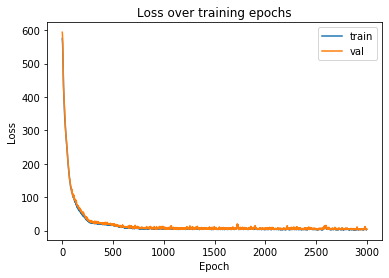

In [46]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

## Inference
This inference is performed on the validation set. You can supply your own test set by generating more data.

In [47]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset: #seq_len x feature
            seq_true = seq_true.to(device)
            seq_true = torch.unsqueeze(seq_true, 0)
            seq_pred = model(seq_true) #model is expecting batchsize x seq_len x feature

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy())
            losses.append(loss.item())
            
    return predictions, losses

In [48]:
test_model = RecurrentAutoencoder(1, seq_len, pred_len, n_features, embedding_dim) #batchsz, seq_len, n_features, embedding dim
test_model = test_model.to(device)
test_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [49]:
def plot_prediction(data, target, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    ax.plot(data[:,0], data[:,1], 'bo', label='true_hist')
    ax.plot(target[:,0], target[:,1], 'go', label='true_future')
    #print('data', data, data.type, data.shape)
    pred = np.reshape(np.array(predictions[0]), (-1,2))
    #print('pred', pred, pred.shape)
    ax.plot(pred[:,0], pred[:,1], 'ro', label='model_pred')
    #print('pred', pred, pred[len(pred)-1,0])
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    print(pred_losses[0])
    ax.legend()

7.042713165283203
8.291115760803223
5.197750568389893
6.9510817527771


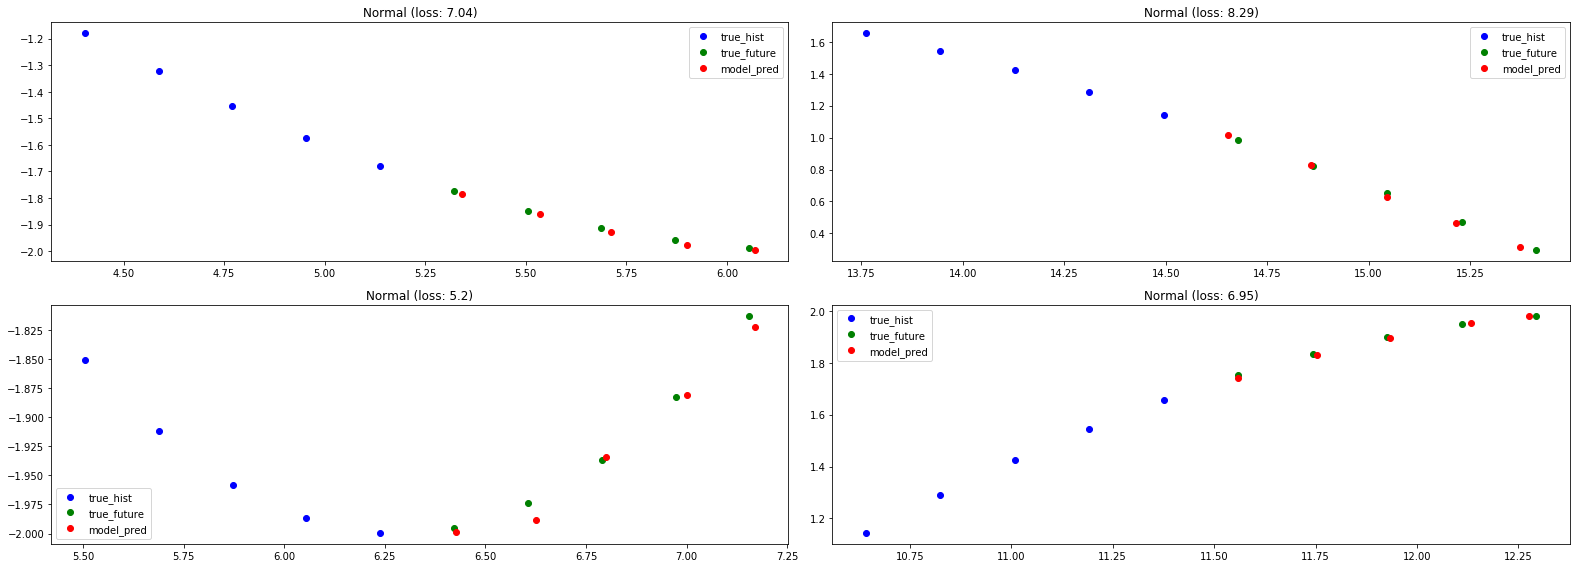

In [50]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=2,
  sharey=False,
  sharex=False,
  figsize=(22, 8)
)

for i,data in enumerate(val_in[:2]):
    for j,data in enumerate(val_in[2:4]):
        plot_prediction(val_in[:4][j+2*i], val_gt[:4][j+2*i], test_model, title='Normal', ax=axs[i,j])

fig.tight_layout();

Try playing around with the model now! Mess with the model hyperparameters, model parameters, and parameters in the dataset.